<p style="font-size:3em;"> Stochastic Block Model Experiment </p> 

<p style="font-size:1em;">This notebook demonstrates the implementation of the following algorithm proposed in the paper 
    <a href="https://arxiv.org/pdf/1705.10467.pdf">Federated Multi-Task Learning</a>
</p>   



<img src="algorithm1.png" align="left" width="600">

<!-- ![alt text](algorithm1.png) -->

In [757]:
import networkx as nx 
from torch.autograd import Variable
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import abc
from abc import ABC

# Linear Model and Optimizer
Define linear model and optimizer applied by algorithm 1

For running your own adapted experiments you can inherit a class from class **Model** to generate different local predictive models and class **Optimizer**  to generate different primal update operators respectively.

In [486]:
class Model(torch.nn.Module):
    def __init__(self,num_features):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1,bias=False) # 2 in and 1 out
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


In [487]:
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()

In [488]:
class LinearModel:
    def __init__(self, tau, features, label):
        
        mtx1 = 2 * tau * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)
        
        mtx2 = 2 * tau * np.dot(features.T, label)
        
        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x.T + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2).T


# The Linear optimizer in Networked Linear Regression section of the paper    
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, old_weight):
        return self.model.forward(old_weight)

# Algorithm1 and main functions
Implementation of algorithm1 and definations of help functions applied in the experiment

In [727]:
def setup_graph_torch(graph,num_datapoints,num_features,noise_std):
    '''
    Set up attributes for each node and initialize weight for each edge
    Input parameters
        graph: A graph generated with stochasitc block model
        num_datapoints: number of datapoints associated with each node
        num_features: number of features of each datapoint
        noise_std: the standard deviation of noise added to labels when synthesizing datapoints
        loss: loss function associated with each local model
        optimizer: optimizer associated with each local model
        model: model associated with each node
    Returns
        graph: graph with nodes attributes setup
        weights: ground true weights for each cluser
    '''
    
    clusters = graph.graph['partition']
    num_clusters = len(clusters)
    m = num_datapoints
    n = num_features
    attr_label=dict()
    ndecntr=0
    # generate groud true weights for each cluster
    weights = np.array([[2,2],[-2,2]])
    
    for cluster_idx in range(num_clusters): 
        current_weight = weights[cluster_idx,:] 
        # iterate nodes to synthesize datapoints and assign loss, model and optimizer
        for dmy in clusters[cluster_idx]:
            X = np.array(np.random.randn(m,n),dtype=np.float32) 
            y = np.dot(X,current_weight).reshape(-1,1) + np.random.normal(0, noise_std) #add noise
            x_data = Variable(torch.from_numpy(X)).to(torch.float32)
            y_data = Variable(torch.from_numpy(y)).to(torch.float32)
            model = Model(n)
            criterion = torch.nn.MSELoss(reduction='mean')
            optimizer = torch.optim.RMSprop(model.parameters())
            init_weight = np.zeros(n)
            attr_label.update({ndecntr:{"weight":init_weight,"cluster":cluster_idx,"features":x_data,\
                                        "label":y_data,"model":model,"optimizer":optimizer,"criterion":criterion}}) 
            ndecntr=ndecntr+1
        
    attr_degree=dict()
    for nodedmy in graph.nodes(data=False):
        tmp = torch.from_numpy(np.array(graph.degree(nodedmy)))
        attr_degree.update({nodedmy:{"degree":tmp}}) 

    nx.set_node_attributes(graph, attr_label)
    nx.set_node_attributes(graph, attr_degree)
    # initialize dual variable on each edge
    for edgevar in graph.edges():
        graph.edges[edgevar]["weight"] =  np.zeros((1,n)) 


    labels = nx.get_node_attributes(graph,"cluster")
    return graph,weights

In [728]:
def setup_graph_linear(graph,num_datapoints,num_features,noise_std):
    '''
    Set up attributes for each node and initialize weight for each edge
    Input parameters
        graph: A graph generated with stochasitc block model
        num_datapoints: number of datapoints associated with each node
        num_features: number of features of each datapoint
        noise_std: the standard deviation of noise added to labels when synthesizing datapoints
    Returns
        graph: graph with nodes attributes setup
        weights: ground true weights for each cluser
    '''
    
    clusters = graph.graph['partition']
    num_clusters = len(clusters)
    m = num_datapoints
    n = num_features
    attr_label=dict()
    ndecntr=0
    # generate groud true weights for each cluster
    weights = np.array([[2,2],[-2,2]],dtype=np.float32)
    # iterate nodes to synthesize datapoints and assign loss, model and optimizer
    for cluster_idx in range(num_clusters): 
        current_weight = weights[cluster_idx,:] 
        for dmy in clusters[cluster_idx]:
            X = np.array(np.random.randn(m,n), dtype=np.float32) 
            y = X.dot(current_weight).reshape(-1,1) + np.array(np.random.normal(0, noise_std),dtype=np.float32) #add noise
            x_data = Variable(torch.from_numpy(X))
            y_data = Variable(torch.from_numpy(y))
            tau = np.array(1/g.degree(dmy))
            model = LinearModel(tau,x_data, y_data)
            optimizer = LinearOptimizer(model)
            init_weight = np.zeros((1,n)) 
            attr_label.update({ndecntr:{"weight":init_weight,"cluster":cluster_idx,"features":x_data,"label":y_data,"model":model,"optimizer":optimizer}}) 
            ndecntr=ndecntr+1
        
    attr_degree=dict()
    for nodedmy in graph.nodes(data=False):
        tmp = torch.from_numpy(np.array(graph.degree(nodedmy)))
        attr_degree.update({nodedmy:{"degree":tmp}}) 

    nx.set_node_attributes(graph, attr_label)
    nx.set_node_attributes(graph, attr_degree)
    # initialize dual variable on each edge
    for edgevar in graph.edges():
        graph.edges[edgevar]["weight"] =  np.zeros((n)) 


    labels = nx.get_node_attributes(graph,"cluster")
    return graph,weights

In [745]:
def get_MSE(g,current_weights,num_nodes,sampleset=False):
    '''
    Calculate mse according to current learned weights for each node
    '''
    X = []
    features = nx.get_node_attributes(g,"features")
    for i in range(num_nodes):
        X.append(features[i].numpy())
    X = np.array(X)

    Y = []
    labels = nx.get_node_attributes(g,"label")
    for i in range(num_nodes):
        Y.append(labels[i].numpy())
    Y = np.array(Y).squeeze()
    
    Y_pred = []
    for i in range(num_nodes):
        Y_pred.append(np.dot(X[i], current_weights[i]).reshape(-1,1))
    Y_pred = np.array(Y_pred).squeeze()
    
    return mean_squared_error(Y, Y_pred)

In [741]:
def get_train_test_MSE(g,current_weights,num_nodes,sampleset):
    '''
    Calculate mse according to current learned weights for each node
    '''
    X = []
    features = nx.get_node_attributes(g,"features")
    for i in range(num_nodes):
        X.append(features[i].numpy())
    X = np.array(X)

    Y = []
    labels = nx.get_node_attributes(g,"label")
    for i in range(num_nodes):
        Y.append(labels[i].numpy())
    Y = np.array(Y).squeeze()
    
    Y_pred = []
    for i in range(num_nodes):
        Y_pred.append(np.dot(X[i], current_weights[i]).reshape(-1,1))
    Y_pred = np.array(Y_pred).squeeze()

    not_sampleset = [i for i in range(num_nodes) if i not in sampleset]
    MSE = {'train': mean_squared_error(Y[sampleset], Y_pred[sampleset]),
            'test': mean_squared_error(Y[not_sampleset], Y_pred[not_sampleset])}
  
    return MSE

In [721]:
def algorithm_sbm_torch(g,sampleset,lambda_nlasso=0.1,K=20,penalty_norm="1norm"):
    '''
    Algorithm simulating distributed environment
    Input parameters
        graph: a already setup graph with nodes atrributes and edge weights
        sampleset: indicators of labeld nodes
        lambda_nlasso: regularizer hyperparameter for GTV term
        K: number of iterations
        penalty_norm: the choice for GTV term, "1norm","2norm" or "sq2norm"
    Returns
        currweights: learned weights for each nodes
        iter_mse: a list of mse calculated for each iteration
    '''
    iter_mse = []
    num_nodes = len(g.nodes)
    for iter_algo in range(K):
        oldnodeweight=nx.get_node_attributes(g,"weight")  # read in current node weight vectors
        # iterate nodes to update nodes associated parameters
        for nodevar in g.nodes(data=False):
            oldweight = oldnodeweight[nodevar]
            dmy=np.zeros(oldweight.shape)
            # iterate over all neighbors of node to realize the update step of Algorihm 1 lines 2-4
            for node_j in g[nodevar]: 
                edgeweighttmp =  g.edges[nodevar,node_j]["weight"]
                if node_j > nodevar:
                    dmy = dmy-edgeweighttmp
                else: 
                    dmy = dmy+edgeweighttmp
            dmy= dmy/g.degree(nodevar); 
            regularizerterm = oldweight - dmy 
            
            # primal update step of Algorithm 1 lines 5-7
            if nodevar in sampleset:
                optimizer = g.nodes[nodevar]["optimizer"]
                model = g.nodes[nodevar]["model"]
                model.linear.weight.data=torch.from_numpy(np.array(regularizerterm, dtype=np.float32)) 
                y_data = g.nodes[nodevar]["label"]
                x_data = g.nodes[nodevar]["features"]
                criterion = g.nodes[nodevar]["criterion"]
                taufac = g.nodes[nodevar]["degree"]
                
#   update the primal variable i.e. solve the proximal operator, with gradient decent method 
                for iterinner in range(5):
                    optimizer.zero_grad()
                    y_pred = model(x_data)
                    
                    loss1 = criterion(y_pred,y_data)
                    loss= loss1+0.5*taufac*torch.mean((model.linear.weight-torch.from_numpy(regularizerterm))**2) 
                   
                    loss.backward()
                    optimizer.step()
                    
                g.nodes[nodevar]["weight"] = model.linear.weight.data.numpy()
            else:
                g.nodes[nodevar]["weight"] = regularizerterm
        # iterate over edges to realize the dual update step of Algorithm 1 lines 8-11
        for edgevar in g.edges(data=False): 
            tmpweight =  g.edges[edgevar]["weight"]
            tailnode=np.min([edgevar[0],edgevar[1]])
            headnode=np.max([edgevar[0],edgevar[1]])
            tmpnodew1 = 2*g.nodes[headnode]["weight"]-oldnodeweight[headnode]
            tmpnodew2 = 2*g.nodes[tailnode]["weight"]-oldnodeweight[tailnode]
            tmp =  tmpweight+(0.9/2)*(tmpnodew1-tmpnodew2)
      #for different TV choice, 1norm, 2norm or squared 2norm, apply corresponding update equation discussed in the paper
            if penalty_norm == "1norm":
                g.edges[edgevar]["weight"] = np.clip(tmp,-lambda_nlasso,lambda_nlasso)
            elif penalty_norm  == "2norm":
                g.edges[edgevar]["weight"] = tmp/np.max([1,np.linalg.norm(tmp,2)/lambda_nlasso])
            elif penalty_norm == "sq2norm":  
                g.edges[edgevar]["weight"] = tmp*lambda_nlasso/(lambda_nlasso+0.9)
            else:
                raise ValueError(f"Invalid Norm")
        temp_weights = nx.get_node_attributes(g,"weight")
        currweights = []
        for nodeidx in g.nodes(data=False):
            currweights.append(temp_weights[nodeidx][0])
        currweights = np.array(currweights)
                
        iter_mse.append(get_MSE(g,currweights,num_nodes))
    return currweights,iter_mse

In [731]:
def algorithm_sbm_linear(g,sampleset,lambda_nlasso=0.1,K=20,penalty_norm="1norm"):
    '''
    Algorithm simulating distributed environment
    Input parameters
        graph: a already setup graph with nodes atrributes and edge weights
        sampleset: indicators of labeld nodes
        lambda_nlasso: regularizer hyperparameter for GTV term
        K: number of iterations
        penalty_norm: the choice for GTV term, "1norm","2norm" or "sq2norm"
    Returns
        currweights: learned weights for each nodes
        iter_mse: a list of mse calculated for each iteration
    '''
    iter_mse = []
    num_nodes = len(g.nodes)
    for iter_algo in range(K):
        oldnodeweight=nx.get_node_attributes(g,"weight")  # read in current node weight vectors
        # iterate nodes to update nodes associated parameters
        for nodevar in g.nodes(data=False):
            oldweight = oldnodeweight[nodevar]
            dmy=np.zeros(oldweight.shape)
            # iterate over all neighbors of node to realize the update step of Algorihm 1 lines 2-4
            for node_j in g[nodevar]: 
                edgeweighttmp =  g.edges[nodevar,node_j]["weight"]
                if node_j > nodevar:
                    dmy = dmy-edgeweighttmp
                else: 
                    dmy = dmy+edgeweighttmp
            dmy= dmy/g.degree(nodevar)
            regularizerterm = oldweight - dmy
            
            if nodevar in sampleset:
                optimizer = g.nodes[nodevar]["optimizer"]
        # update the primal variable with a closed form solution of the proximal operator
                g.nodes[nodevar]["weight"] = optimizer.optimize(regularizerterm)
            else:
                g.nodes[nodevar]["weight"] = regularizerterm
                
        # iterate over edges to realize the dual update step of Algorithm 1 lines 8-11
        for edgevar in g.edges(data=False): 
            tmpweight =  g.edges[edgevar]["weight"]
            tailnode=np.min([edgevar[0],edgevar[1]])
            headnode=np.max([edgevar[0],edgevar[1]])
            tmpnodew1 = 2*g.nodes[headnode]["weight"]-oldnodeweight[headnode]
            tmpnodew2 = 2*g.nodes[tailnode]["weight"]-oldnodeweight[tailnode]
            tmp =  tmpweight+(0.9/2)*(tmpnodew1-tmpnodew2)
          #for different TV choice, 1norm, 2norm or squared 2norm, apply corresponding update equation discussed in the paper
            if penalty_norm == "1norm":
                g.edges[edgevar]["weight"] = np.clip(tmp,-lambda_nlasso,lambda_nlasso)
            elif penalty_norm  == "2norm":
                g.edges[edgevar]["weight"] = tmp/np.max([1,np.linalg.norm(tmp,2)/lambda_nlasso])
            elif penalty_norm == "sq2norm":  
                g.edges[edgevar]["weight"] = tmp*lambda_nlasso/(lambda_nlasso+0.9)
            else:
                raise ValueError(f"Invalid Norm")
        temp_weights = nx.get_node_attributes(g,"weight")
        currweights = []
        for nodeidx in g.nodes(data=False):
            currweights.append(temp_weights[nodeidx][0])
        currweights = np.array(currweights)
                
        iter_mse.append(get_MSE(g,currweights,num_nodes))
    return currweights,iter_mse

In [840]:
'''---TEST---'''
cluster_sizes = [100,100]
probs = [[0.5, 0.01], [0.01, 0.5]]
g_t = nx.stochastic_block_model(cluster_sizes, probs)
sampleset_size = int(sum(cluster_sizes)*0.4)
sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)
print(sampleset)

num_datapoints = 5
num_features = 2
g_t,true_weights = setup_graph_linear(g_t,num_datapoints,num_features,noise_std=0)
trained_weights,iter_mse = algorithm_sbm_linear(g_t,sampleset,lambda_nlasso=0.01,K=1000,penalty_norm='2norm')
trained_weights
iter_mse[-1]

[183 150 154  11 117 178   6  55  51  58  34  84  46  87   9 144 116 155
  38  30 114  57 124  26  22 168 119  94 140 161 136  82 173  42 182 180
  52 165 104  76  12 176 135  66   7 184  41 112   2  43 132  23  17  59
  29  35 139 138  64 131  44   8 152  48  62  93  89 106 156 175  74  90
 192  97  92 120  95  72 146  61]


5.115307241534425e-06

# Main experiments
We use a network built with stochastic block models as a benchmark to examine algorithm1
## SBM settings
The SBM applied in this experiment has two clusters C<sub>1</sub> and C<sub>2</sub>.
Two nodes within the same cluster are connected by an edge with probability `pin` fixed to be 0.5, 
and two nodes from different clusters are connected by an edge with probability `pout` which will be experimented with different values. 
Each node i &in; V represents a local dataset consisting of 
`m` feature vectors 
x<sup>(i,1)</sup>, ... , x<sup>(i,m)</sup> &in; R<sup>n</sup> . 
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,1).
The labels y<sup>i</sup><sub>1</sub>, ... , y<sup>i</sup><sub>m</sub> &in; R for each node i &in; V
are generated according to the linear equation y<sup>i</sup><sub>r</sub> = (x<sup>(i, r)</sup>)<sup>T</sup>w&#772;<sup>(i)</sup> +  &epsilon; , 
with &epsilon; &in; N(0,&sigma;), weight vector w<sup>(i)</sup> = (2, 2)<sup>T</sup>
for i &in; C<sub>1</sub>, and w<sup>(i)</sup> = (-2, 2)<sup>T</sup> for i &in; C<sub>2</sub> will serve as ground true paremeters.
## Examine the performance of algorithm1 
Randomly selecting a certain ratio of datasets as seeds, e.g. 0.2,0.4,0.6,or 0.8, using different hyperparameter combinations, we examine the performance of algorithm1 and do hyperparameter searching.

### Compare with Global LinearRegression and DecisionTree models

In [907]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [870]:
def get_X_Y(g,num_nodes):
    X= []
    features = nx.get_node_attributes(g,"features")
    for i in range(num_nodes):
        X.append(features[i].numpy())
    

    Y = []
    labels = nx.get_node_attributes(g,"label")
    for i in range(num_nodes):
        Y.append(labels[i].numpy())
        
        
    X = np.array(X).squeeze()

    Y = np.array(Y).squeeze()
    return X,Y

In [1020]:
def get_mean_std_test_mse():
    test_mses=[]
    test_mse_std=[]

    test_1norm=[]
    for mse in mse_1norm:
        test_1norm.append(mse['test'])
    test_mses.append(np.mean(test_1norm))
    test_mse_std.append(np.std(test_1norm))
    
    test_2norm=[]
    for mse in mse_2norm:
        test_2norm.append(mse['test'])
    test_mses.append(np.mean(test_2norm))
    test_mse_std.append(np.std(test_2norm))

    test_sq2norm=[]
    for mse in mse_sq2norm:
        test_sq2norm.append(mse['test'])
    test_mses.append(np.mean(test_sq2norm))
    test_mse_std.append(np.std(test_sq2norm))
    
    test_lr=[]
    for mse in mse_lr:
        test_lr.append(mse['test'])
    test_mses.append(np.mean(test_lr))
    test_mse_std.append(np.std(test_lr))
    

    test_dt=[]
    for mse in mse_dt:
        test_dt.append(mse['test'])
    test_mses.append(np.mean(test_dt))
    test_mse_std.append(np.std(test_dt))

    return np.array(test_mses),np.array(test_mse_std)
def get_mean_std_train_mse():
    train_mses=[]
    train_mse_std=[]

    train_1norm=[]
    for mse in mse_1norm:
        train_1norm.append(mse['train'])
    train_mses.append(np.mean(train_1norm))
    train_mse_std.append(np.std(train_1norm))
    
    train_2norm=[]
    for mse in mse_2norm:
        train_2norm.append(mse['train'])
    train_mses.append(np.mean(train_2norm))
    train_mse_std.append(np.std(train_2norm))

    train_sq2norm=[]
    for mse in mse_sq2norm:
        train_sq2norm.append(mse['train'])
    train_mses.append(np.mean(train_sq2norm))
    train_mse_std.append(np.std(train_sq2norm))
    
    train_lr=[]
    for mse in mse_lr:
        train_lr.append(mse['train'])
    train_mses.append(np.mean(train_lr))
    train_mse_std.append(np.std(train_lr))
    

    train_dt=[]
    for mse in mse_dt:
        train_dt.append(mse['train'])
    train_mses.append(np.mean(train_dt))
    train_mse_std.append(np.std(train_dt))

    return np.array(train_mses),np.array(train_mse_std)

In [975]:
cluster_sizes = [100,100]
probs = [[0.5, 0.01], [0.01, 0.5]]
sampleset_size = int(sum(cluster_sizes)*0.4)

num_datapoints = 5
num_features = 2


mse_1norm = []
mse_2norm = []
mse_sq2norm = []
mse_lr = []
mse_dt = []

for i in range(5): # repeat the simulation for five times
    print(i)
    g,true_weights = setup_graph_linear(g,num_datapoints,num_features,noise_std=0)
    
    
    sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)
    not_sampleset = [i for i in range(200) if i not in sampleset]
#     print(len(not_sampleset))
    
    trained_weights,iter_mse = algorithm_sbm_linear(g,sampleset,lambda_nlasso=0.01,K=1000,penalty_norm='1norm')
    mse_1norm.append(get_train_test_MSE(g,trained_weights,200,sampleset))
    
    
    trained_weights,iter_mse = algorithm_sbm_linear(g,sampleset,lambda_nlasso=0.01,K=1000,penalty_norm='2norm')
    mse_2norm.append(get_train_test_MSE(g,trained_weights,200,sampleset))
    
    trained_weights,iter_mse = algorithm_sbm_linear(g,sampleset,lambda_nlasso=0.01,K=1000,penalty_norm='sq2norm')
    mse_sq2norm.append(get_train_test_MSE(g,trained_weights,200,sampleset))
    
    X,Y = get_X_Y(g,200)
    X_train = X[sampleset].reshape(400,2)
    Y_train = Y[sampleset].reshape(400,1)
    X_test = X[not_sampleset].reshape(600,2)
    Y_test = Y[not_sampleset].reshape(600,1)
    
    model_1 = LinearRegression().fit(X_train,Y_train)
    Y_pred_train_1 = model_1.predict(X_train)
    Y_pred_test_1 = model_1.predict(X_test)
    
    mse_lr.append({'train': mean_squared_error(Y_train,Y_pred_train_1),
                             'test': mean_squared_error(Y_test,
                                                        Y_pred_test_1)})

    
    model_2 = DecisionTreeRegressor(max_depth=2).fit(X_train,Y_train)
    Y_pred_train_2 = model_2.predict(X_train)
    Y_pred_test_2 = model_2.predict(X_test)
    mse_dt.append({'train': mean_squared_error(Y_train,Y_pred_train_2),
                             'test': mean_squared_error(Y_test,Y_pred_test_2)})
    
    

0
1
2
3
4


In [1048]:
mse_sq2norm

[{'train': 5.788311650136597e-05, 'test': 0.040751842351055625},
 {'train': 4.583216742737563e-05, 'test': 0.04128290102564948},
 {'train': 4.911472613316021e-05, 'test': 0.04014644208229274},
 {'train': 4.520456665210161e-05, 'test': 0.04143674818127068},
 {'train': 4.8758284476275344e-05, 'test': 0.04625540411974928}]

Train MSE:

1norm
8.271311072295922e-06 

2norm
8.299728424350026e-06 

sq2norm
4.935857223805575e-05 

linear regression
4.003998756408691 

decision tree
4.114771621049142 

Test MSE:

1norm
8.72554993585754e-06 

2norm
8.831939341305146e-06 

sq2norm
0.04197466755200356 

linear regression
4.2015509605407715 

decision tree
4.764473540883787 



Text(0.5, 1.0, 'test_MSE V.S. Methods with error bars')

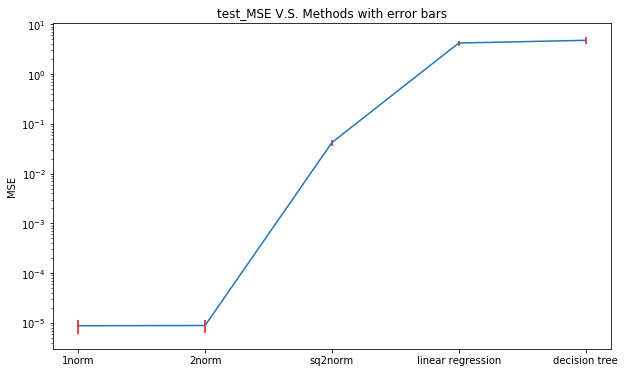

In [1050]:
methods = ['1norm','2norm','sq2norm','linear regression','decision tree']
train_mses, train_mse_std = get_mean_std_train_mse()
test_mses, test_mse_std = get_mean_std_test_mse()

print('Train MSE:\n')
for i, method in enumerate(methods):
    print(method)
    print(train_mses[i],'\n')
print('Test MSE:\n')

for i, method in enumerate(methods):
    print(method)
    print(test_mses[i],'\n')
    
fig = plt.figure(figsize=(10,6))
ax = fig.subplots()
ax.set_yscale('log')
ax.errorbar(methods, test_mses, yerr=test_mse_std*2.576, ecolor='r', label='both limits (default)')
ax.set_ylabel('MSE')
ax.set_title('test_MSE V.S. Methods with error bars')

### Different pouts and noises for each penalty function with fixed lambda

penalty_func: 1norm
noise 0.01
MSE: {0.001: 8.054236112064516e-05, 0.01: 0.0004210034096250228, 0.05: 0.007595525123056532, 0.1: 0.02787315340933893, 0.2: 0.1108931368067428, 0.4: 2.2543870227454197}
noise 0.1
MSE: {0.001: 0.0093344193565275, 0.01: 0.01186037127898856, 0.05: 0.017116000006680166, 0.1: 0.03540375319841713, 0.2: 0.1337373785582951, 0.4: 2.128985689760925}
noise 1.0
MSE: {0.001: 1.0526669267221882, 0.01: 0.9720372893082324, 0.05: 0.854711865749412, 0.1: 0.8350547903572287, 0.2: 1.127969756780814, 0.4: 3.0635561599743957}


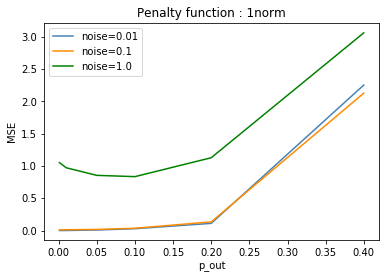

penalty_func: 2norm
noise 0.01
MSE: {0.001: 9.287996745906653e-05, 0.01: 0.00044946974889597386, 0.05: 0.007697077840759815, 0.1: 0.028519778810383496, 0.2: 0.17373487869166965, 0.4: 1.9688651341232941}
noise 0.1
MSE: {0.001: 0.009230158843296933, 0.01: 0.011007562983018766, 0.05: 0.017794946295567104, 0.1: 0.03853737003740594, 0.2: 0.12137705341577007, 0.4: 3.1165657264070363}
noise 1.0
MSE: {0.001: 0.7824634716023371, 0.01: 0.7883467687809994, 0.05: 0.7439305617085782, 0.1: 0.8827589527335069, 0.2: 1.13217092326822, 0.4: 3.178409040503249}


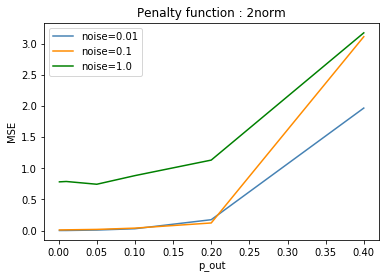

penalty_func: sq2norm
noise 0.01
MSE: {0.001: 0.0009578531986543109, 0.01: 0.020139495121220225, 0.05: 0.2540607593851036, 0.1: 0.5662147051283036, 0.2: 1.104724587853595, 0.4: 1.5614318275960481}
noise 0.1
MSE: {0.001: 0.009355264516179986, 0.01: 0.02919923361548748, 0.05: 0.23432027845285158, 0.1: 0.4990779490856839, 0.2: 1.036620633775706, 0.4: 1.708666891001124}
noise 1.0
MSE: {0.001: 0.8344608220839473, 0.01: 0.8583676696332742, 0.05: 1.0550604001912984, 0.1: 1.4065380590435625, 0.2: 2.1793390973748883, 0.4: 2.6778134063821026}


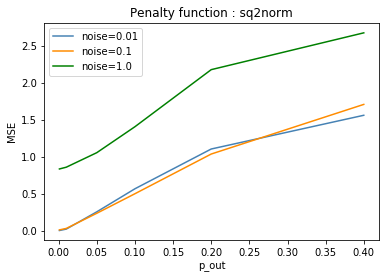

In [636]:
lambda_lasso = 0.1
sampling_ratio = 0.6
pouts = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4]
norms = ["1norm","2norm","sq2norm"]
cluster_sizes = [100,100]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for norm in norms:
    print('penalty_func:', norm)
    for i, noise in enumerate([0.01, 0.1, 1.0]):
        MSEs = {}
        for pout in pouts:
            probs = [[0.5, pout], [pout, 0.5]]
            g = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
            sampleset_size = int(sum(cluster_sizes)*0.6)
            sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)

            num_datapoints = 5
            num_features = 2
            g,true_weights = setup_graph_linear(g,num_datapoints,num_features,noise)

            trained_weights,iter_mse = algorithm_sbm_linear(g,sampleset,lambda_nlasso=lambda_lasso,K=200,penalty_norm=norm)


            MSEs[pout] = iter_mse[-1]
        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='noise=' + str(noise), c=colors[i])

        print('noise', noise)
        print('MSE:', MSEs)

    plt.xlabel('p_out')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % norm)
    plt.show()
    plt.close()

### Different pouts and sampling ratios for each penalty function with fixed lambda




penalty_func: 1norm

M: 0.2
MSE: {0.001: 0.00011606849402463144, 0.01: 0.005585280384610312, 0.05: 0.10385413310776981, 0.1: 3.4288329290459663, 0.2: 3.6685677216721637, 0.4: 3.0280001691474014}

M: 0.4
MSE: {0.001: 2.000598613641056e-06, 0.01: 0.0008260923699904834, 0.05: 0.016983297725918917, 0.1: 0.10462186270763955, 0.2: 2.400336294590183, 0.4: 3.839435528118333}

M: 0.6
MSE: {0.001: 2.8481024745106967e-06, 0.01: 0.00021880866912920845, 0.05: 0.007423573241701942, 0.1: 0.03261781373448839, 0.2: 0.13642457270650857, 0.4: 2.2578370333935815}


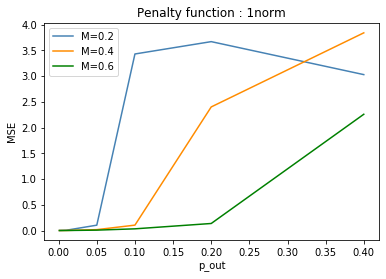


penalty_func: 2norm

M: 0.2
MSE: {0.001: 0.008338453619742196, 0.01: 0.01005054960443679, 0.05: 0.7655975622545401, 0.1: 3.782435240724425, 0.2: 3.651873992920045, 0.4: 3.2899695658898125}

M: 0.4
MSE: {0.001: 2.715692099429514e-06, 0.01: 0.0009190880777583205, 0.05: 0.015116237867376429, 0.1: 0.061221870959506895, 0.2: 2.7679381030244663, 0.4: 2.885721448179322}

M: 0.6
MSE: {0.001: 2.9437926071434425e-06, 0.01: 0.00028184558225518663, 0.05: 0.009497090957723577, 0.1: 0.03026882794201493, 0.2: 0.12457932518440058, 0.4: 2.024462861700921}


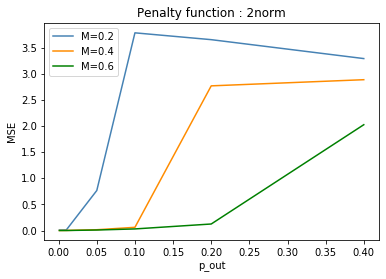


penalty_func: sq2norm

M: 0.2
MSE: {0.001: 0.4617437224298201, 0.01: 0.5987965635157292, 0.05: 1.5379242130507502, 0.1: 2.165086463989969, 0.2: 2.999733153716469, 0.4: 3.639384296881564}

M: 0.4
MSE: {0.001: 0.026280432936316267, 0.01: 0.08919966223101967, 0.05: 0.5716732075525676, 0.1: 1.1424946502998208, 0.2: 1.7565507277910477, 0.4: 2.3614050030787226}

M: 0.6
MSE: {0.001: 0.0007397611136730285, 0.01: 0.017680390461697247, 0.05: 0.18976216594321804, 0.1: 0.5841358203077937, 0.2: 1.1437337246657813, 0.4: 1.7500870595064661}


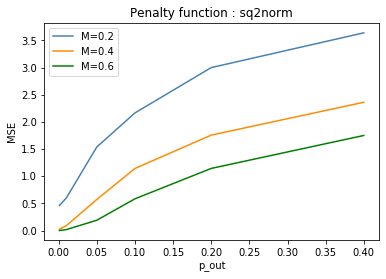

In [600]:
lambda_lasso = 0.1
pouts = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4]

norms = ["1norm","2norm","sq2norm"]
cluster_sizes = [100,100]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for norm in norms:
    print('\npenalty_func:', norm)
    for i, sampling_ratio in enumerate([0.2, 0.4, 0.6]):
        MSEs = {}
        for pout in pouts:
            probs = [[0.5, pout], [pout, 0.5]]
            g = nx.stochastic_block_model(cluster_sizes, probs)
            num_datapoints = 5
            num_features = 2
            num_nodes = len(g.nodes(data=False))
            sampleset_size = int(sum(cluster_sizes)*sampling_ratio)
       
            sampleset = np.random.choice([j for j in range(sum(cluster_sizes))],sampleset_size,replace=False)
      
            g,true_weights = setup_graph_linear(g,num_datapoints,num_features,0)

            trained_weights,iter_mse = algorithm_sbm_linear(g,sampleset,lambda_nlasso=lambda_lasso,K=200,penalty_norm=norm)

            mse = iter_mse[-1]
            MSEs[pout] = mse
       
        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='M=' + str(sampling_ratio), c=colors[i])

        print('\nM:', sampling_ratio)
        print('MSE:', MSEs)
    
    plt.xlabel('p_out')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % norm)
    plt.show()
    plt.close()



### Different Lambdas for each penalty function with pout=0.001
The aim of  this experiment is to search for ideal hyperparmeter $ \lambda $ for different Total variation choice, 1norm, 2norm or squared 2norm.


Penalty_func: 1norm

MSE: {1.0: 0.08970028694045017, 0.1: 1.9979390902561706e-05, 0.05: 3.1055590412116244e-05, 0.01: 1.6013546581112177, 0.001: 5.532047652960804}


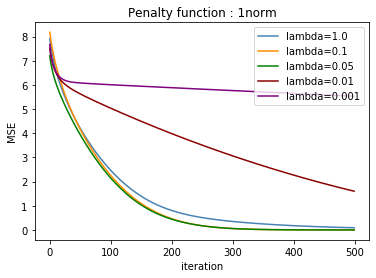

Penalty_func: 2norm

MSE: {1.0: 0.04411294235448714, 0.1: 1.7782326470604985e-05, 0.05: 3.969271546694109e-05, 0.01: 2.6881969739093066, 0.001: 5.819160337281303}


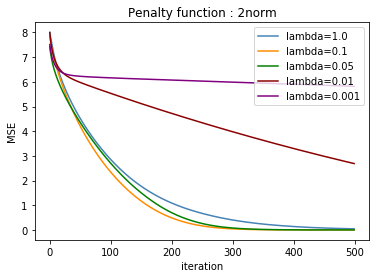

Penalty_func: sq2norm

MSE: {1.0: 0.09560381341537726, 0.1: 0.007673071032764356, 0.05: 0.06107594417852298, 0.01: 1.1765953450298716, 0.001: 5.187335769857846}


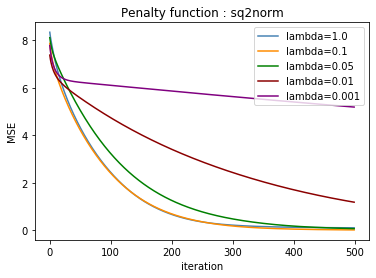

In [391]:
POUT = 0.001
K = 500
x1 = [i for i in range(K)]
probs = [[0.5, POUT], [POUT, 0.5]]

fig = plt.figure(figsize=(10,5))

norms = ["1norm","2norm","sq2norm"]
lambda_lassos = [1.0, 0.1, 0.05, 0.01, 0.001]
cluster_sizes = [100,100]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for norm in norms:
    plt.close()
    MSEs = {}
    
    for i, lambd in enumerate(lambda_lassos):
        g = nx.stochastic_block_model(cluster_sizes, probs)
        sampleset_size = int(sum(cluster_sizes)*0.2)
        sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)

        num_datapoints = 5
        num_features = 2
        g,true_weights = setup_graph_torch(g,num_datapoints,num_features,noise_std=0)

        trained_weights,iter_mse = algorithm_sbm_torch(g,sampleset,lambda_nlasso=lambd,K=K,penalty_norm=norm)

        plt.plot(x1, iter_mse, label='lambda='+str(lambd), c=colors[i])
        MSEs[lambd] = iter_mse[-1]
    print('Penalty_func:', norm)
    print('\nMSE:', MSEs)
    
    plt.xlabel('iteration')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % norm)
    plt.legend(loc='best')
    plt.show()

### Different sampling ratios for each penalty functions with pout=0.001

The aim of this experiment is to explore the impact of sample ratio on the performance of Algorithm1 for different Total variation choice, 1norm, 2norm or squared 2norm.


penalty_func: 1norm

MSE: {0.2: 0.0819821888604811, 0.4: 1.5598148406963888e-05, 0.6: 1.7826495142629038e-05, 0.8: 1.5655034002154884e-05, 1.0: 1.9205947e-05}


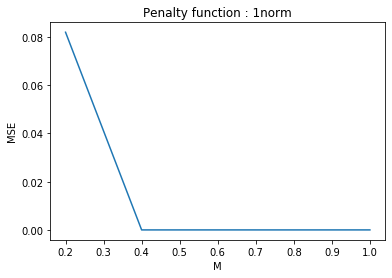

penalty_func: 2norm

MSE: {0.2: 0.03435472084346073, 0.4: 8.524478445442503e-06, 0.6: 1.7711528615006982e-05, 0.8: 3.2538235431485714e-05, 1.0: 2.5926438e-05}


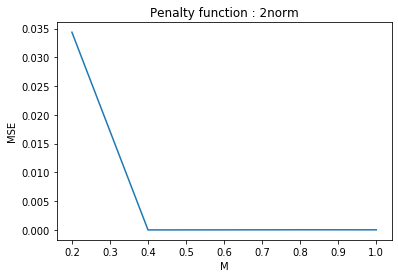

penalty_func: sq2norm

MSE: {0.2: 0.2716992515268074, 0.4: 0.01306684486497708, 0.6: 0.0009624569843964543, 0.8: 0.00043623276829706827, 1.0: 0.00049089955}


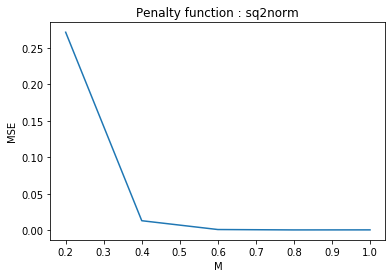

In [599]:
fig = plt.figure(figsize=(10,5))

POUT = 0.001

lambda_lassos = {'1norm': 0.1, '2norm': 0.1, 'sq2norm': 1.0}
probs = [[0.5, POUT], [POUT, 0.5]]
norms = ["1norm","2norm","sq2norm"]
sample_ratios = [0.2,0.4,0.6,0.8,1.0]
cluster_sizes = [100,100]
colors = ['steelblue', 'darkorange', 'green', 'darkred', 'purple']

for norm in norms:
    MSEs = {}
    for i,sr in enumerate(sample_ratios):
        g = nx.stochastic_block_model(cluster_sizes, probs)
        sampleset_size = int(sum(cluster_sizes)*sr)
        sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)
        num_datapoints = 5
        num_features = 2
        g,true_weights = setup_graph_torch(g,num_datapoints,num_features,noise_std=0)
        lambda_nlasso = lambda_lassos[norm]
        trained_weights,iter_mse = algorithm_sbm_torch(g,sampleset,lambda_nlasso,K=300,penalty_norm=norm)
        MSEs[sr] = iter_mse[-1]

    print('penalty_func:', norm)
    print('\nMSE:', MSEs)
    
    plt.close()
    plt.plot(list(MSEs.keys()), list(MSEs.values()))
    plt.xlabel('M')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % norm)
    plt.show()

### Different pouts and noises for each penalty function with fixed lambda

penalty_func: 1norm pout: 0.0
noise MSE: {0: 4.90634611611059e-06, 0.01: 0.00010726285443445372, 0.1: 0.010279225967249717}
penalty_func: 1norm pout: 0.001
noise MSE: {0: 2.234052797280666e-05, 0.01: 0.0001025300600668288, 0.1: 0.009949281560396182}
penalty_func: 1norm pout: 0.1
noise MSE: {0: 4.164610994631275, 0.01: 4.964503320571635, 0.1: 3.9880340081716015}
penalty_func: 1norm pout: 0.2
noise MSE: {0: 4.017682247325054, 0.01: 5.505375482283247, 0.1: 4.129288578906115}
penalty_func: 1norm pout: 0.6
noise MSE: {0: 4.1501379012567154, 0.01: 4.442489068654611, 0.1: 4.305931639111507}


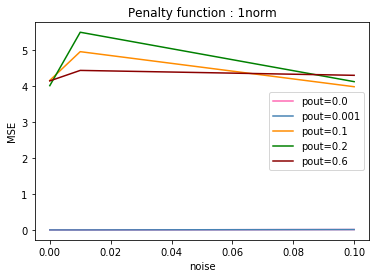

penalty_func: 2norm pout: 0.0
noise MSE: {0: 4.8891536612701265e-06, 0.01: 0.0021512156792534358, 0.1: 0.010102023979625327}
penalty_func: 2norm pout: 0.001
noise MSE: {0: 1.3371315013581316e-05, 0.01: 0.00010691729623255114, 0.1: 0.009251704406698796}
penalty_func: 2norm pout: 0.1
noise MSE: {0: 4.0034225845379705, 0.01: 4.598874883698085, 0.1: 4.025695381874149}
penalty_func: 2norm pout: 0.2
noise MSE: {0: 3.991241333958192, 0.01: 5.023298307882304, 0.1: 4.8655984472790745}
penalty_func: 2norm pout: 0.6
noise MSE: {0: 4.143261181295548, 0.01: 4.150084072597924, 0.1: 3.9967778048374973}


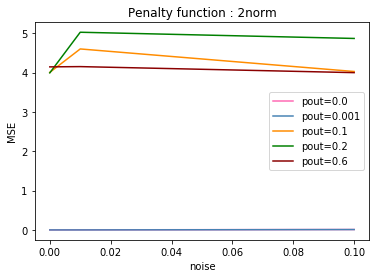

penalty_func: sq2norm pout: 0.0
noise MSE: {0: 8.516503397142782e-05, 0.01: 0.0001309340297528751, 0.1: 0.009284966177788524}
penalty_func: sq2norm pout: 0.001
noise MSE: {0: 0.541688284087048, 0.01: 0.134119669921132, 0.1: 1.0164038684366212}
penalty_func: sq2norm pout: 0.1
noise MSE: {0: 3.859387635888742, 0.01: 4.0745610783291495, 0.1: 3.7671323549994553}
penalty_func: sq2norm pout: 0.2
noise MSE: {0: 3.595915560031611, 0.01: 4.202253156951706, 0.1: 4.258565175592838}
penalty_func: sq2norm pout: 0.6
noise MSE: {0: 4.572854529151901, 0.01: 3.838463530877905, 0.1: 4.170192517995541}


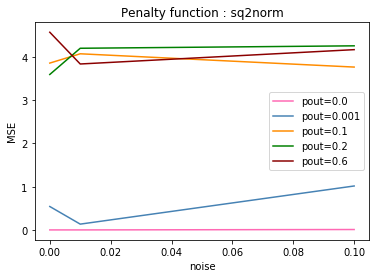

In [575]:
cluster_sizes = [100,100]
lambda_lassos = {'1norm': 0.1, '2norm': 0.1, 'sq2norm': 1.0}
colors = ['hotpink', 'steelblue', 'darkorange', 'green', 'darkred', 'purple', 'dimgrey']
pouts = [0.0, 0.001, 0.1, 0.2, 0.6]
noises = [0, 0.01, 0.1]

for norm in ['1norm','2norm','sq2norm']:
    
    for i, pout in enumerate(pouts):
        
        MSEs = {}
        for noise in noises:
            probs = [[0.5, pout], [pout, 0.5]]
            g = nx.stochastic_block_model(cluster_sizes, probs)
            sampleset_size = int(sum(cluster_sizes)*0.2)
            sampleset = np.random.choice([i for i in range(sum(cluster_sizes))],sampleset_size,replace=False)

            num_datapoints = 5
            num_features = 2
            g,true_weights = setup_graph_torch(g,num_datapoints,num_features,noise)
            lambda_lasso = lambda_lassos[norm]
            trained_weights,iter_mse = algorithm_sbm_torch(g,sampleset,lambda_nlasso=lambda_lasso,K=500,penalty_norm=norm)


            MSEs[noise] = iter_mse[-1]

        plt.plot(list(MSEs.keys()), list(MSEs.values()), label='pout='+str(pout), c=colors[i])
        print('penalty_func:', norm, 'pout:', pout)
        print('noise MSE:', MSEs)
        
    plt.xlabel('noise')
    plt.ylabel('MSE')
    plt.title('Penalty function : %s' % norm)
    plt.legend(loc='best')
    plt.show()
    plt.close()